In [ ]:
pip install transformers==2.6.0

     |████████████████████████████████| 542kB 8.6MB/s 
     |████████████████████████████████| 1.2MB 40.0MB/s 
     |████████████████████████████████| 133kB 57.2MB/s 
     |████████████████████████████████| 5.6MB 27.3MB/s 
     |████████████████████████████████| 901kB 46.6MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 7.7MB 48.4MB/s 
ERROR: botocore 1.20.109 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv('/content/drive/My Drive/Thesis/clean_ner_all_campaign_data.csv',encoding="UTF-8" )



In [ ]:
data =data.fillna(method ="ffill")

In [ ]:
data.head(30)

,sentence_no,data,Word,position,Tag
0,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,এরশাদকে,1,B-PER
1,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,নিয়ে,2,O
2,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,গণতন্ত্র,3,O
3,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,হত্যা,4,O
4,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,করেছে,5,O
5,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,শেখ,6,B-PER
6,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,হাসিনা,7,I-PER
7,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,-,8,O
8,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,মির্জা,9,B-PER
9,1,এরশাদকে নিয়ে গণতন্ত্র হত্যা করেছে শেখ হাসিনা -...,ফখরুল,10,I-PER


In [ ]:
data.tail(10)

,sentence_no,data,Word,position,Tag
165704,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,দৃষ্টান্তমূলক,4,O
165705,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,শাস্তির,5,O
165706,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,দাবিতে,6,O
165707,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,শিক্ষকদের,7,O
165708,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,কর্মবিরতির,8,O
165709,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,ঘোষণা,9,O
165710,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,দিয়েছে,10,O
165711,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,বিশ্ববিদ্যালয়,11,B-ORG
165712,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,শিক্ষক,12,I-ORG
165713,14716,এ ঘটনায় হামলাকারীদের দৃষ্টান্তমূলক শাস্তির দাব...,সমিতি,13,I-ORG


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_no").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter = SentenceGetter(data)


In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]


['এরশাদকে',
 'নিয়ে',
 'গণতন্ত্র',
 'হত্যা',
 'করেছে',
 'শেখ',
 'হাসিনা',
 '-',
 'মির্জা',
 'ফখরুল']

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])


['B-PER', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.9.0+cu102'

In [ ]:
MAX_LEN = 75
bs = 32


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [ ]:
torch.cuda.get_device_name(0)


'Tesla T4'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        #word = word.astype(str)
        #label = label.astype(str)
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'2.6.0'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "sagorsarker/bangla-bert-base",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:

from transformers import get_linear_schedule_with_warmup

epochs = 14
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
pip install seqeval

     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=c3a8885a8b469940a5c8a0ea98d26f5b75eeb1360f12b2e5c5617b392da2861e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score


In [ ]:
from seqeval.metrics import precision_score
from seqeval.metrics import accuracy_score
from seqeval.metrics import recall_score

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
acc_values, validation_acc_values = [], []
f1_values = []
precision_values = []
recall_values = []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    validation_acc_values.append(accuracy_score(pred_tags, valid_tags))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    f1_values.append(f1_score([pred_tags], [valid_tags]))
    precision_values.append(precision_score([pred_tags], [valid_tags]))
    recall_values.append(recall_score([pred_tags], [valid_tags]))
    print()


Epoch:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.3318008642743179
Validation loss: 0.15857046852378467
Validation Accuracy: 0.9502223148534111
Validation F1-Score: 0.7410649161196208


Epoch:   7%|▋         | 1/14 [02:29<32:29, 149.99s/it]


Average train loss: 0.13834919484238242
Validation loss: 0.14863623413992555
Validation Accuracy: 0.9554675559260803
Validation F1-Score: 0.7853782120883098


Epoch:  14%|█▍        | 2/14 [05:05<30:21, 151.79s/it]


Average train loss: 0.08388579322318118
Validation loss: 0.14376087712222024
Validation Accuracy: 0.958837015423093
Validation F1-Score: 0.804165144318597


Epoch:  21%|██▏       | 3/14 [07:42<28:03, 153.08s/it]


Average train loss: 0.05569512020514653
Validation loss: 0.15686605429570927
Validation Accuracy: 0.9573086008058913
Validation F1-Score: 0.7977729885057472


Epoch:  29%|██▊       | 4/14 [10:18<25:39, 153.99s/it]


Average train loss: 0.03829678392745223
Validation loss: 0.16410817156888938
Validation Accuracy: 0.9625538418785605
Validation F1-Score: 0.8241206030150754


Epoch:  36%|███▌      | 5/14 [12:54<23:11, 154.60s/it]


Average train loss: 0.026891630777166133
Validation loss: 0.17887670438932746
Validation Accuracy: 0.958698068639711
Validation F1-Score: 0.8060352663152154


Epoch:  43%|████▎     | 6/14 [15:29<20:39, 154.93s/it]


Average train loss: 0.018826095710331656
Validation loss: 0.1818371412197226
Validation Accuracy: 0.9610949006530499
Validation F1-Score: 0.8237869390733309


Epoch:  50%|█████     | 7/14 [18:05<18:06, 155.18s/it]


Average train loss: 0.014220522814057215
Validation loss: 0.19538852297946027
Validation Accuracy: 0.9628664721411699
Validation F1-Score: 0.8245484703280501


Epoch:  57%|█████▋    | 8/14 [20:41<15:31, 155.27s/it]


Average train loss: 0.009359778935253448
Validation loss: 0.21350840292870998
Validation Accuracy: 0.9611296373488953
Validation F1-Score: 0.8222744530826251


Epoch:  64%|██████▍   | 9/14 [23:16<12:56, 155.27s/it]


Average train loss: 0.006651817334448651
Validation loss: 0.2290562395692656
Validation Accuracy: 0.9635264693622343
Validation F1-Score: 0.8302996874425448


Epoch:  71%|███████▏  | 10/14 [25:51<10:20, 155.23s/it]


Average train loss: 0.004724930410813306
Validation loss: 0.24051857671063198
Validation Accuracy: 0.9621022648325691
Validation F1-Score: 0.82687338501292


Epoch:  79%|███████▊  | 11/14 [28:26<07:45, 155.14s/it]


Average train loss: 0.003699195130983556
Validation loss: 0.23597778203456024
Validation Accuracy: 0.9636306794497708
Validation F1-Score: 0.8346744696415509


Epoch:  86%|████████▌ | 12/14 [31:01<05:10, 155.13s/it]


Average train loss: 0.0029097547142903557
Validation loss: 0.2408285119423741
Validation Accuracy: 0.9622759483117966
Validation F1-Score: 0.8297795446331766


Epoch:  93%|█████████▎| 13/14 [33:36<02:35, 155.09s/it]


Average train loss: 0.0019913219113316723
Validation loss: 0.24348102274693942
Validation Accuracy: 0.9625538418785605
Validation F1-Score: 0.829518403222853


Epoch: 100%|██████████| 14/14 [36:11<00:00, 155.10s/it]

In [ ]:
f1_score??

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print("accuary: ", accuracy_score([pred_tags], [valid_tags]))
print("precision: ", precision_score([pred_tags], [valid_tags]))
print("recall: ", recall_score([pred_tags], [valid_tags]))
print("f1 score: ", f1_score([pred_tags], [valid_tags]))

accuary:  0.9625538418785605
precision:  0.8278508771929824
recall:  0.8311926605504587
f1 score:  0.829518403222853


In [ ]:
print(classification_report([pred_tags], [valid_tags], mode='strict'))

              precision    recall  f1-score   support

        Date       0.85      0.88      0.86       244
         EVE       0.38      0.47      0.42        60
         LOC       0.80      0.85      0.83       861
         ORG       0.78      0.76      0.77       557
         PER       0.90      0.90      0.90       949

   micro avg       0.83      0.84      0.84      2671
   macro avg       0.74      0.77      0.76      2671
weighted avg       0.83      0.84      0.84      2671



In [ ]:
print("f1 score: ", f1_score([pred_tags], [valid_tags], average= 'macro'))

f1 score:  0.7477519421838861


In [ ]:
pred_tags

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'O',
 'B-ORG',
 'B-ORG',
 'I-ORG',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'I-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'B-LOC',
 'B-LOC',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 '

In [ ]:
type(pred_tags[0])

str

In [ ]:
valid_tags

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'B-LOC',
 'B-LOC',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',


In [ ]:
len(pred_tags)

28788

In [ ]:
len(valid_tags)

28788

In [ ]:
value = len(pred_tags)

In [ ]:
value

28788

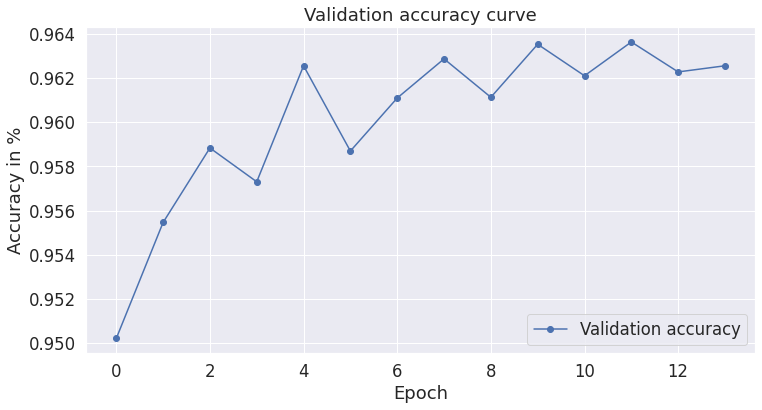

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(validation_acc_values, 'b-o', label="Validation accuracy")
#plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Validation accuracy curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy in %")
plt.legend()

plt.show()

In [ ]:
from zipfile import *
with ZipFile('/content/drive/My Drive/Thesis/corpus/category/sports.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('temp')
from pathlib import Path
in_list = ""
out = dict()
out.setdefault("word",[])
out.setdefault("prediction",[])
j=0
for path in Path("temp/sports").iterdir():
  if path.is_file() and j<100:
    j+=1
    current_file = open(path, "r")
    in_list+=current_file.read()
    current_file.close()

FileNotFoundError: ignored

In [ ]:
test_sentence = """
 বঙ্গবন্ধু শেখ মুজিবুর রহমান  ১৯৭১ সালে বাংলাদেশের স্বাধীনতার ডাক দেন।
"""

In [ ]:
test_sentence = in_list

NameError: ignored

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
  output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
  out["word"].append(token)
  out["prediction"].append(label)
res = pd.DataFrame(out)
res.columns = ["word","prediction"]
res.to_csv("/content/drive/My Drive/Thesis/sports_prediction_results.csv",mode="a")

NameError: ignored

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

B-PER	[CLS]
B-PER	বঙগবনধ
I-PER	শেখ
I-PER	মজিবর
I-PER	রহমান
B-Date	[UNK]
O	সালে
B-LOC	বাংলাদেশের
O	সবাধীনতার
O	ডাক
O	দেন
O	।
O	[SEP]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Training and validation loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss in %")
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(f1_values, 'b-o', label="F1-score")
plt.plot(precision_values, 'r-o', label="Precision")
plt.plot(recall_values, 'g-o', label="Recall")

# Label the plot.
plt.title("Precision, Recall and F1-score curve")
plt.xlabel("Epoch")
plt.ylabel("Loss in percentage")
plt.legend()

plt.show()